In [1]:
import tensorflow

import pandas as pd
import numpy as np #데이터 배열화
import os #경로 설정용 
import keras #딥러닝용 패키지
import random #데이터 분산할 때 쓸 랜덤
import cv2 #이미지 읽기용
import math #연산용
import seaborn as sns #matplotlib에 다양한 시각화 기능이 추가된 패키지

from sklearn.metrics import confusion_matrix #분류의 정확성 평가
from sklearn.preprocessing import LabelBinarizer #데이터 전처리용
from sklearn.model_selection import train_test_split #데이터 분할용

import matplotlib.pyplot as plt #데이터 시각화용

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization #사용할 BN, ConV2 등의 계층
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout #사용할 레이어

from tensorflow.keras.applications import DenseNet121 #Densenet121 모델 사용
from tensorflow.keras.applications.densenet import preprocess_input #tensor나 numpy배열 전처리용

from tensorflow.keras.preprocessing import image #이미지 데이터를 실시간으로 처리하기 위한 도구
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array #이미지 편집을 위한 제너레이터(Affine Transform)

from tensorflow.keras.models import Model #교육 및 추론 기능이 있는 개체로 레이어를 그룹화

from tensorflow.keras.optimizers import Adam #Adam 옵티마이저 사용. loss는 categorical_crossentropy 사용

#체크포인트를 두고 저장 + metric이 중지되면 학습률을 감소
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 

import warnings #경고 무시
warnings.filterwarnings("ignore")

In [2]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(48, 48, 3)) #채널이 무조건 3개여야 하며 크기는 최소 32 이상

x=model_d.output

x= GlobalAveragePooling2D()(x) #전역 평균 풀링 레이어 추가
x= BatchNormalization()(x) #배치 정규화 레이어
x= Dropout(0.2)(x)
#Fully Connected 레이어 추가
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.2)(x) #과적합 감소용 드롭아웃 레이어

preds=Dense(6,activation='softmax')(x) #FC-layer. 클래스가 7개이므로 softmax 7개 설정

In [3]:
model=Model(inputs=model_d.input,outputs=preds) 
model.summary() #모델 요약

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 24, 24, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [4]:
#Freeze
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [5]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy']) #모델 생성
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 24, 24, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

                                                                 conv4_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block22_0_bn (BatchNormal (None, 3, 3, 928)    3712        conv4_block21_concat[0][0]       
__________________________________________________________________________________________________
conv4_block22_0_relu (Activatio (None, 3, 3, 928)    0           conv4_block22_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block22_1_conv (Conv2D)   (None, 3, 3, 128)    118784      conv4_block22_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block22_1_bn (BatchNormal (None, 3, 3, 128)    512         conv4_block22_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_bloc

In [6]:
data=[] #데이터
labels=[] #라벨
random.seed(42)
imagePaths = sorted(list(os.listdir("emotion_FixedVer/"))) #데이터셋 경로
random.shuffle(imagePaths) #셔플
print(imagePaths)
#이미지 읽기 및 라벨링
for img in imagePaths:
    path=sorted(list(os.listdir("emotion_FixedVer/"+img)))
    for i in path:
        image = cv2.imread("emotion_FixedVer/"+img+'/'+i) #이미지 읽기
        image = cv2.resize(image, (48,48)) #이미지 사이즈 편집
        image = img_to_array(image) #이미지 배열화
        data.append(image) #data 배열에 데이터 추가
        l = label = img
        labels.append(l) #labels 배열에 데이터 추가

['neutral', 'fearful', 'happy', 'sad', 'angry', 'surprised']


In [7]:
data = np.array(data, dtype="float32") / 255.0 #데이터 타입 변경 및 numpy 배열화
labels = np.array(labels) #라벨 numpy 배열화
mlb = LabelBinarizer() #데이터 전처리(원핫인코딩)
labels = mlb.fit_transform(labels) #데이터에 대해서 fit 작업과 transform 작업을 적용해주는 것
print(labels[0])

[0 0 0 1 0 0]


In [8]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.3,random_state=42) #train용과 test용으로 데이터셋 분리. test 30%
print(xtrain.shape, xtest.shape)

(19507, 48, 48, 3) (8361, 48, 48, 3)


In [9]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [10]:
#검증 손실에 변화가 없는 경우 학습률을 감소시켜 도움을 줌
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4) 
checkpoint = ModelCheckpoint('Densenet121_revised2.h5', verbose=1, save_best_only=True) #체크포인트를 두고 모델 저장

datagen = ImageDataGenerator(zoom_range = 0.3, horizontal_flip=True, shear_range=0.3) #이미지 가공(학습률 향상을 위한 augmentation)


datagen.fit(xtrain)
# 모델 학습
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=64),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=150,
               verbose=2,#verbose 2는 '세대 당 한 라인'을 의미
               callbacks=[anne, checkpoint], #학습과 검증 과정에서 적용할 콜백 리스트
               validation_data=(xtrain, ytrain)) #steps_per_epoch일 때 사용하는 것으로 샘플 배치 데이터 수

Epoch 1/150
152/152 - 33s - loss: 1.9828 - accuracy: 0.3089 - val_loss: 1.6185 - val_accuracy: 0.3685

Epoch 00001: val_loss improved from inf to 1.61846, saving model to Densenet121_revised2.h5
Epoch 2/150
152/152 - 19s - loss: 1.6735 - accuracy: 0.3477 - val_loss: 1.5242 - val_accuracy: 0.3922

Epoch 00002: val_loss improved from 1.61846 to 1.52423, saving model to Densenet121_revised2.h5
Epoch 3/150
152/152 - 20s - loss: 1.6041 - accuracy: 0.3722 - val_loss: 1.4720 - val_accuracy: 0.4182

Epoch 00003: val_loss improved from 1.52423 to 1.47198, saving model to Densenet121_revised2.h5
Epoch 4/150
152/152 - 21s - loss: 1.5818 - accuracy: 0.3756 - val_loss: 1.4714 - val_accuracy: 0.4177

Epoch 00004: val_loss improved from 1.47198 to 1.47142, saving model to Densenet121_revised2.h5
Epoch 5/150
152/152 - 21s - loss: 1.5553 - accuracy: 0.3870 - val_loss: 1.4477 - val_accuracy: 0.4318

Epoch 00005: val_loss improved from 1.47142 to 1.44773, saving model to Densenet121_revised2.h5
Epoch 6/1


Epoch 00047: val_loss improved from 1.17701 to 1.17296, saving model to Densenet121_revised2.h5
Epoch 48/150
152/152 - 20s - loss: 1.3169 - accuracy: 0.4896 - val_loss: 1.1622 - val_accuracy: 0.5626

Epoch 00048: val_loss improved from 1.17296 to 1.16219, saving model to Densenet121_revised2.h5
Epoch 49/150
152/152 - 21s - loss: 1.3043 - accuracy: 0.4941 - val_loss: 1.1653 - val_accuracy: 0.5589

Epoch 00049: val_loss did not improve from 1.16219
Epoch 50/150
152/152 - 21s - loss: 1.2843 - accuracy: 0.5083 - val_loss: 1.1687 - val_accuracy: 0.5539

Epoch 00050: val_loss did not improve from 1.16219
Epoch 51/150
152/152 - 20s - loss: 1.3006 - accuracy: 0.4981 - val_loss: 1.1906 - val_accuracy: 0.5493

Epoch 00051: val_loss did not improve from 1.16219
Epoch 52/150
152/152 - 21s - loss: 1.2981 - accuracy: 0.4959 - val_loss: 1.1426 - val_accuracy: 0.5670

Epoch 00052: val_loss improved from 1.16219 to 1.14259, saving model to Densenet121_revised2.h5
Epoch 53/150
152/152 - 21s - loss: 1.2


Epoch 00092: val_loss improved from 0.93672 to 0.93184, saving model to Densenet121_revised2.h5
Epoch 93/150
152/152 - 21s - loss: 1.1243 - accuracy: 0.5742 - val_loss: 0.9288 - val_accuracy: 0.6594

Epoch 00093: val_loss improved from 0.93184 to 0.92883, saving model to Densenet121_revised2.h5
Epoch 94/150
152/152 - 21s - loss: 1.1375 - accuracy: 0.5706 - val_loss: 0.9350 - val_accuracy: 0.6570

Epoch 00094: val_loss did not improve from 0.92883
Epoch 95/150
152/152 - 21s - loss: 1.1266 - accuracy: 0.5729 - val_loss: 0.9265 - val_accuracy: 0.6574

Epoch 00095: val_loss improved from 0.92883 to 0.92654, saving model to Densenet121_revised2.h5
Epoch 96/150
152/152 - 21s - loss: 1.1305 - accuracy: 0.5762 - val_loss: 0.9138 - val_accuracy: 0.6692

Epoch 00096: val_loss improved from 0.92654 to 0.91377, saving model to Densenet121_revised2.h5
Epoch 97/150
152/152 - 20s - loss: 1.1295 - accuracy: 0.5693 - val_loss: 0.9168 - val_accuracy: 0.6612

Epoch 00097: val_loss did not improve from 0

Epoch 136/150
152/152 - 20s - loss: 0.9573 - accuracy: 0.6369 - val_loss: 0.7289 - val_accuracy: 0.7432

Epoch 00136: val_loss improved from 0.73059 to 0.72895, saving model to Densenet121_revised2.h5
Epoch 137/150
152/152 - 20s - loss: 0.9715 - accuracy: 0.6381 - val_loss: 0.7348 - val_accuracy: 0.7356

Epoch 00137: val_loss did not improve from 0.72895
Epoch 138/150
152/152 - 21s - loss: 0.9559 - accuracy: 0.6432 - val_loss: 0.7223 - val_accuracy: 0.7416

Epoch 00138: val_loss improved from 0.72895 to 0.72232, saving model to Densenet121_revised2.h5
Epoch 139/150
152/152 - 21s - loss: 0.9718 - accuracy: 0.6396 - val_loss: 0.7217 - val_accuracy: 0.7433

Epoch 00139: val_loss improved from 0.72232 to 0.72172, saving model to Densenet121_revised2.h5
Epoch 140/150
152/152 - 21s - loss: 0.9533 - accuracy: 0.6437 - val_loss: 0.7336 - val_accuracy: 0.7366

Epoch 00140: val_loss did not improve from 0.72172
Epoch 141/150
152/152 - 21s - loss: 0.9424 - accuracy: 0.6427 - val_loss: 0.7212 - va

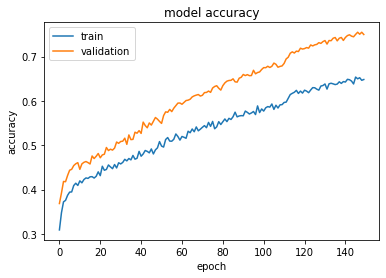

In [11]:
plot_hist(history)

In [12]:
#완성도 확인
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]): #가장 큰 값을 찾아 인덱스 반환
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 8361 	accurately-predicted-data: 4033 	 wrongly-predicted-data:  4328
Accuracy: 48.236 %


In [13]:
model.evaluate(xtest, ytest, batch_size = 32)

262/262 [==============================] - 7s 28ms/step - loss: 1.5006 - accuracy: 0.4824


[1.5005556344985962, 0.48235857486724854]